### Human In the Loop

**Review**
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

**Goals**
Now, let's talk about the motivations for human-in-the-loop:

(1) **Approval** - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) **Debugging** - We can rewind the graph to reproduce or avoid issues

(3) **Editing** - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

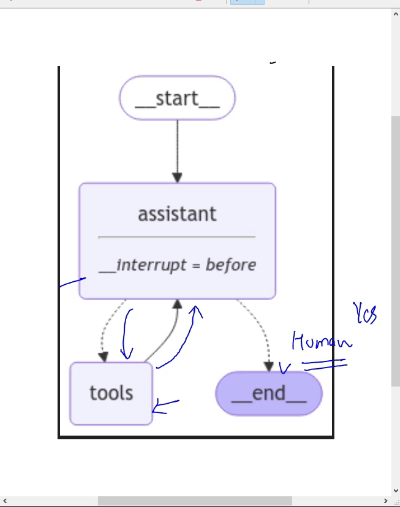

In [ ]:
#🧪 STEP 1: Load Environment and Initialize LLM
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq

# Set the API Key from env variables
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

# Load the Groq model
llm = ChatGroq(model="llama-3.3-70b-versatile")

# Simple test to check if LLM is working
result = llm.invoke("Hello")
result
# AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.01727233, 'prompt_time': 0.010857541, 'queue_time': 0.045646448, 'total_time': 0.028129871}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--48cd561d-a09a-4dbb-8f8c-207dbcf2bef5-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})


# 📌 This sets up and tests your LLM with Groq using the new qwen-qwq-32b model.

#🧰 STEP 2: Define Custom Tools
### Custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.
    
    Args:
        a: first int
        b: second int
    """
    return a / b

# Store tools in a list
tools=[add,multiply,divide]
tools
# [<function __main__.add(a: int, b: int) -> int>,
#  <function __main__.multiply(a: int, b: int) -> int>,
#  <function __main__.divide(a: int, b: int) -> float>]

#📌 These are your custom tool functions that the assistant will be able to use during the workflow.

#🔗 STEP 3: Bind Tools with LLM
llm_with_tools=llm.bind_tools(tools)
llm_with_tools
# RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001E1EE6018D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E1EE4B22D0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

#📌 This allows the language model to call your custom tools like multiply or add when needed

#🔄 STEP 4: Define the Assistant Node Logic
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

# System Message (prompt for LLM)
# System Message -> my llm how to behave
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# creating 3 node assistant and tools and end
# Assistant function
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}
#📌 The assistant function takes messages and runs them through the LLM, with the system message prepended.

#🧱 STEP 5: Create the LangGraph Workflow
# Initialize graph
builder=StateGraph(MessagesState)

# Add assistant and tools nodes
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
#📌 You are creating two main nodes:
#•	assistant: LLM logic
#•	tools: custom arithmetic tools

#🔁 STEP 6: Define the Edges (Flow of the Graph)
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools","assistant")
# 📌 Edges control the flow:
# •	Start → Assistant
# •	Assistant → Tools (if tool call) or End
# •	Tools → Assistant (to continue after tool call)



AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.01727233, 'prompt_time': 0.010857541, 'queue_time': 0.045646448, 'total_time': 0.028129871}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--48cd561d-a09a-4dbb-8f8c-207dbcf2bef5-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

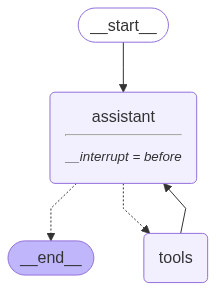

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

# System Message (prompt for LLM)
# System Message -> my llm how to behave
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# creating 3 node assistant and tools and end
# Assistant function
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}
#📌 The assistant function takes messages and runs them through the LLM, with the system message prepended.

#🧱 STEP 5: Create the LangGraph Workflow
# Initialize graph
builder=StateGraph(MessagesState)

# Add assistant and tools nodes
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
#📌 You are creating two main nodes:
#•	assistant: LLM logic
#•	tools: custom arithmetic tools

#🔁 STEP 6: Define the Edges (Flow of the Graph)
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to
    tools_condition,

)
builder.add_edge("tools","assistant")
# 📌 Edges control the flow:
# •	Start → Assistant
# •	Assistant → Tools (if tool call) or End
# •	Tools → Assistant (to continue after tool call)

#👀 STEP 7: Add Human-in-the-Loop (Interrupt)
memory=MemorySaver()

# Interrupt before assistant
graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

# Show the graph structure
display(Image(graph.get_graph().draw_mermaid_png()))
#📌 This uses interrupt_before=["assistant"] which will pause the graph before assistant runs and wait for human input.


In [ ]:
#🚀 STEP 8: Run the Workflow (First Run)
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()
# ================================[1m Human Message [0m=================================

# Multiply 2 and 3

#📌 Starts the graph. Since we have interrupt_before, it will stop before running the assistant and wait.


#🔄 STEP 9: Check the State and Continue Execution
state=graph.get_state(thread)
state.next
# ('assistant',)

graph.get_state_history(thread)
state
# StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c6351832-6387-4ad4-8bb9-ccc1637e5d66')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f093a64-48a6-6c7f-8000-c6713809c6f9'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-17T09:11:17.226201+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f093a64-48a1-6d95-bfff-3cb9dced918f'}}, tasks=(PregelTask(id='f814dda9-2d31-bce1-2ecd-7dea6ff316d0', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

#📌 Check the current state of the graph (useful for debugging or resuming).


================================ Human Message =================================

Multiply 2 and 3


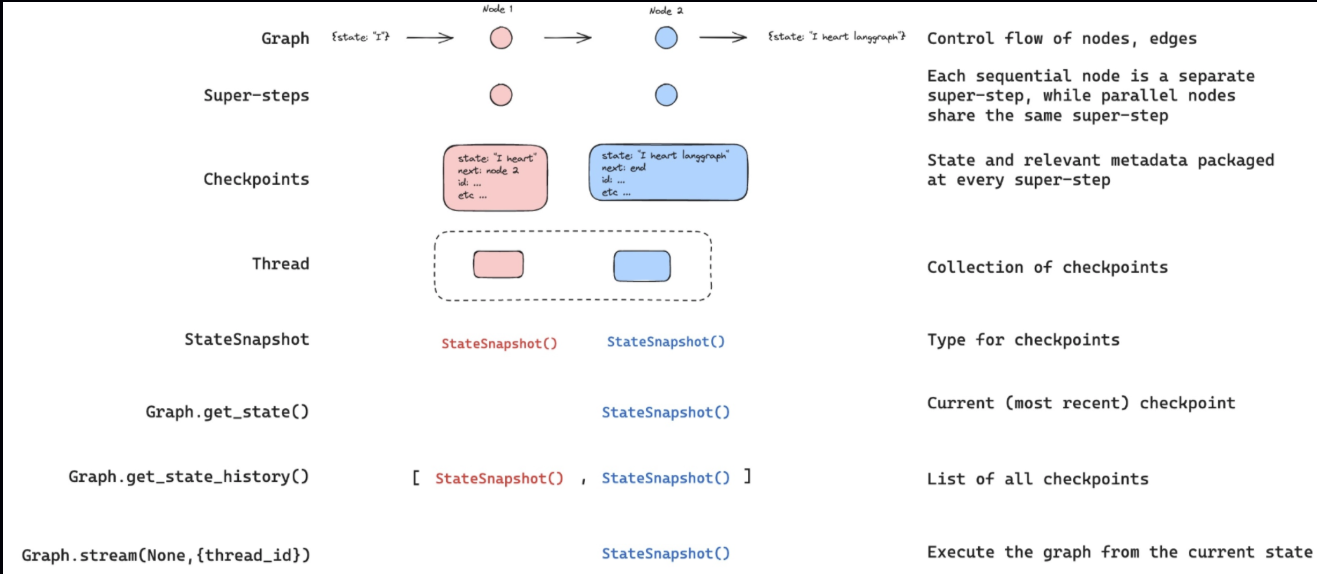

In [ ]:
#▶️ STEP 10: Continue Execution After Interruption
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()
# ================================[1m Human Message [0m=================================

# Multiply 2 and 3
# ==================================[1m Ai Message [0m==================================
# Tool Calls:
#   multiply (c64kpmbb8)
#  Call ID: c64kpmbb8
#   Args:
#     a: 2
#     b: 3
# =================================[1m Tool Message [0m=================================
# Name: multiply

# 6

#📌 Continue the execution from where it was paused (after human feedback).


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (c64kpmbb8)
 Call ID: c64kpmbb8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


### Edit Human Feedback

In [ ]:
#🔁 STEP 11: Run Another Flow and Check State
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}
thread={"configurable":{"thread_id":"1"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()
# ================================[1m Human Message [0m=================================

# Multiply 2 and 3

state=graph.get_state(thread)
state.next
# ('assistant',)
# #📌 Another example with a different thread_id.

#✏️ STEP 12: Modify the Message Mid-Way
graph.update_state(thread,{"messages":[HumanMessage(content="No,please multiply 15 and 6")]})
# {'configurable': {'thread_id': '1',
#   'checkpoint_ns': '',
#   'checkpoint_id': '1f093a93-6144-661e-8005-2f3d343481b7'}}
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()
# Multiply 2 and 3
# ================================ Human Message =================================

# No,please multiply 15 and 6

#📌 You can change the message after interruption — simulating a correction by the human.

#🔁 STEP 13: Resume Graph After Update
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
# ================================== Ai Message ==================================
# Tool Calls:
#   multiply (aq6qxw275)
#  Call ID: aq6qxw275
#   Args:
#     a: 15
#     b: 6
# ================================= Tool Message =================================
# Name: multiply

# 90




#📌 Resume again after human has changed the input.


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,please multiply 15 and 6
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,please multiply 15 and 6
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,please multiply 15 and 6
================================ Human Message =============================

### Workflow will wait for user input

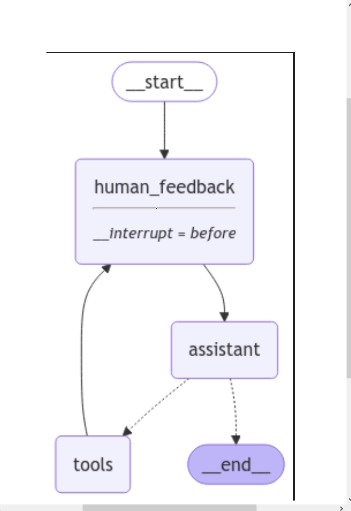

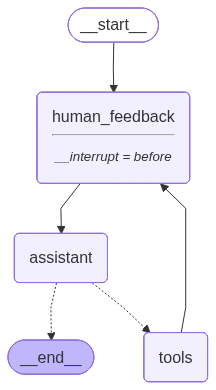

In [21]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Custom human feedback node (currently pass)
def human_feedback(state:MessagesState):
    pass

# Assistant node
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
#📌 You're preparing to insert an actual node called human_feedback.

#🧱 Create a Graph with Human Feedback Node
builder = StateGraph(MessagesState)

# Add all nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Edges
builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools","human_feedback")

# Compile with interrupt before human_feedback
memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

# Show graph
display(Image(graph.get_graph().draw_mermaid_png()))
#📌 Here, you're making the human_feedback node part of the graph flow, not just using interrupt_before.


In [ ]:
#📝 STEP 14: Input, Pause, and Update at Human Feedback Node
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# First run (should pause at human_feedback)
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# User provides new input
user_input=input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Resume execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
# ================================[1m Human Message [0m=================================

# Multiply 2 and 3
# ================================[1m Human Message [0m=================================

# please multiply 10 and 20
# ==================================[1m Ai Message [0m==================================
# Tool Calls:
#   multiply (7rgbakx6k)
#  Call ID: 7rgbakx6k
#   Args:
#     a: 10
#     b: 20
# =================================[1m Tool Message [0m=================================
# Name: multiply

# 200

# 📌 This simulates a real human in the loop:
# •	It stops at human_feedback
# •	You ask the user to change/update the message
# •	Then you continue running the graph


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

please multiply 10 and 20
================================== Ai Message ==================================
Tool Calls:
  multiply (7rgbakx6k)
 Call ID: 7rgbakx6k
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: multiply

200
